### Sustained Attention Response Time (SART) task ERP analysis: signal pre-processing
EEG signal filtering, artefact rejection, and segmenting based on the events.

In [30]:
# Import packages
import mne, os
import numpy as np
import matplotlib.pyplot as plt
from autoreject import (get_rejection_threshold, AutoReject)

# Set the default directory
os.chdir('/Users/tanijarv/Documents/GitHub/EEG-pyline')
mne.set_log_level('error')

# Import functions
import signal_processing.pre_process as prep
import basic.arrange_data as arrange

Define these variables!

In [31]:
# Folder where to get the raw EEG files
raw_folder = 'Data/Raw/'

# Folder where to export the clean epochs files
clean_folder = 'Data/Clean/'

# Sub-folder for the experiment (i.e. timepoint or group)
exp_folder = 'LEISURE/T1/SART'

# EOG + mastoid channels and stimulus channel
eog_channels = ['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8']
stimulus_channel = 'Status'

# Parameters for filter design
filter_design = dict(l_freq=1, h_freq=30, filter_length='auto', method='fir',
                     l_trans_bandwidth='auto', h_trans_bandwidth='auto',
                     phase='zero', fir_window='hamming', fir_design='firwin')

# Epoch time window from event/stimuli
tminmax = [-0.2, 1] #[-0.2, 0.8]

# Baseline correction time window
baseline_correction = None # (None, 0)

# Event names with IDs for GO and NO-GO trials
event_dict = {'GO trial': 4,
              'NO-GO trial': 8}

# Button press ID
button_id = 16

Run this to set the folders for data.

In [25]:
# Get directories of raw EEG files and set export directory for clean files
dir_inprogress = os.path.join(raw_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,'.bdf')

Files in Data/Raw/LEISURE/T1/SART read in: 94


Run this to pre-process the raw EEG files to clean epochs objects.

NOTE: removed baseline correction from here and need to do it later


HBA_0001_SART_T1 (1 / 94)


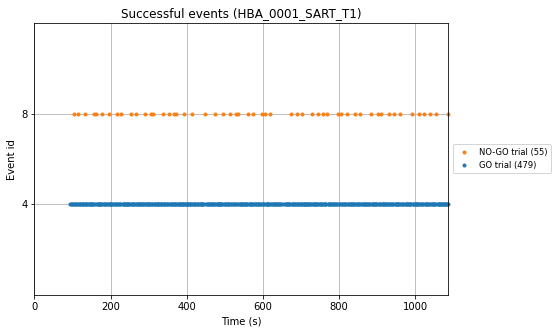

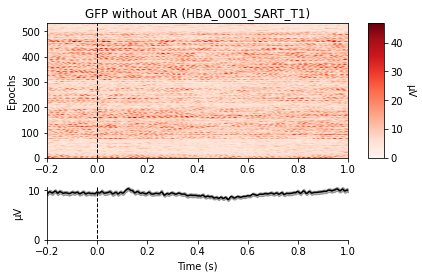

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.0004183130944968368}
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=1


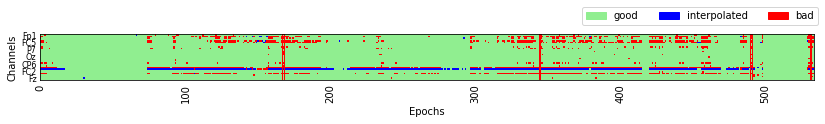

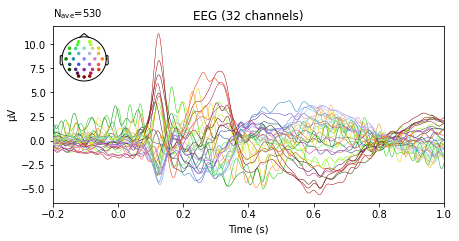

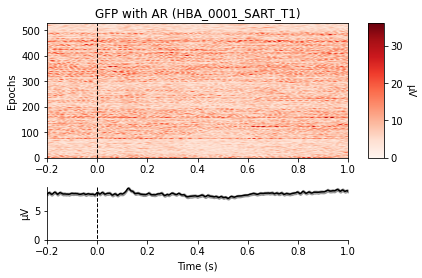

Number of events,530
Events,GO trial: 475NO-GO trial: 55
Time range,-0.200 – 1.000 sec
Baseline,off



HBA_0003_SART_T1 (2 / 94)


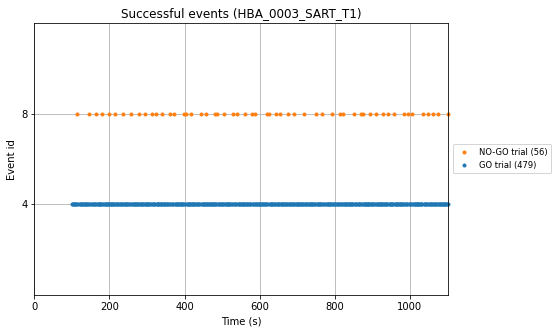

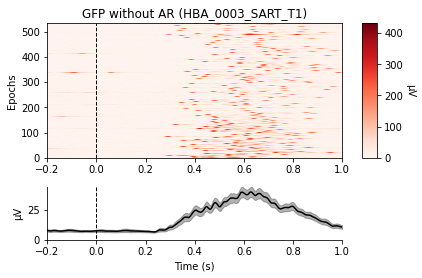

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00182006716145865}
Running autoreject on ch_type=eeg




Estimated consensus=0.40 and n_interpolate=4


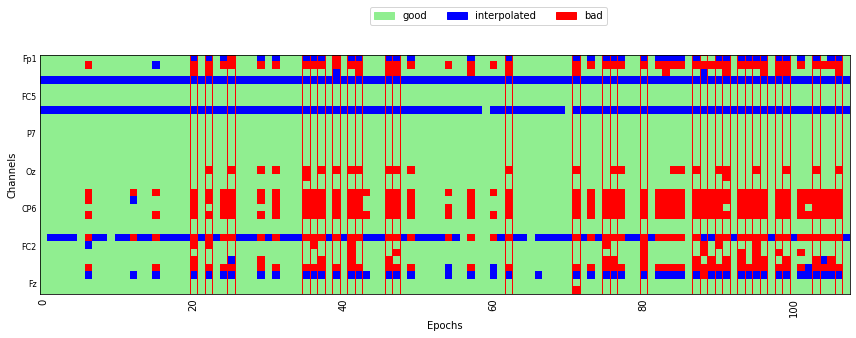

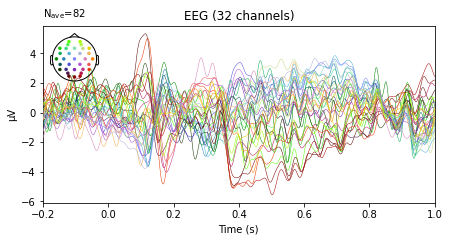

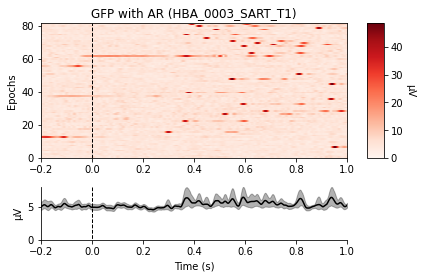

Number of events,82
Events,GO trial: 26NO-GO trial: 56
Time range,-0.200 – 1.000 sec
Baseline,off



HBA_0004_SART_T1 (3 / 94)


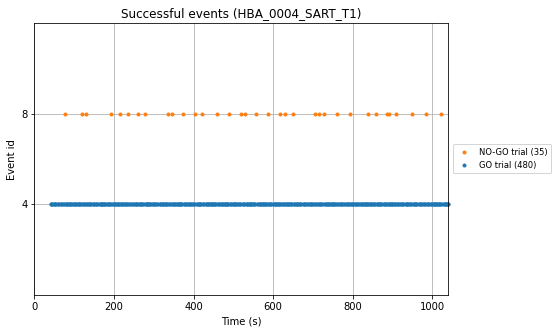

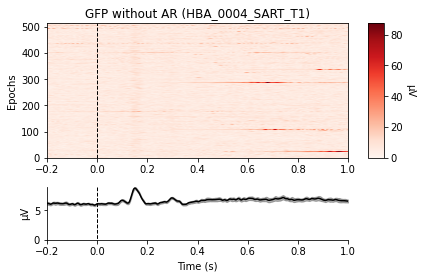

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.0001330455615751614}
Running autoreject on ch_type=eeg




Estimated consensus=0.50 and n_interpolate=4


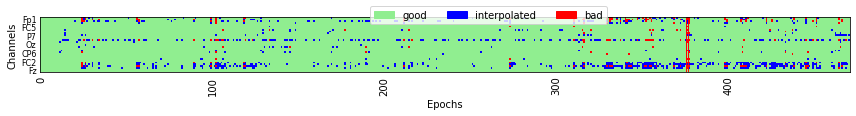

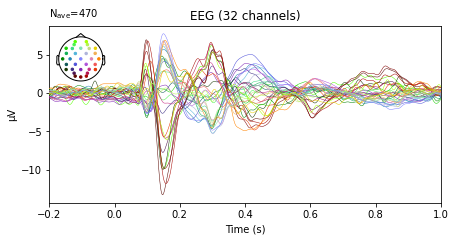

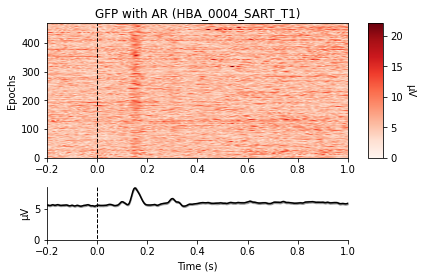

Number of events,470
Events,GO trial: 435NO-GO trial: 35
Time range,-0.200 – 1.000 sec
Baseline,off



HBA_0005_SART_T1 (4 / 94)


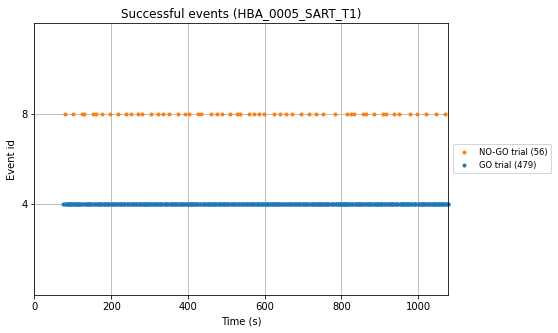

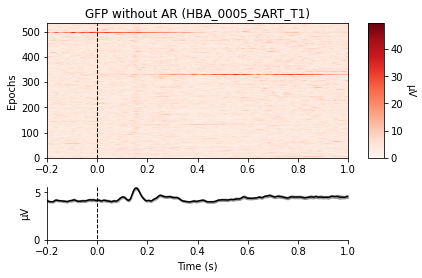

Estimating rejection dictionary for eeg
Dropping epochs with rejection threshold: {'eeg': 0.00011926703653026608}
Running autoreject on ch_type=eeg




Estimated consensus=0.30 and n_interpolate=1


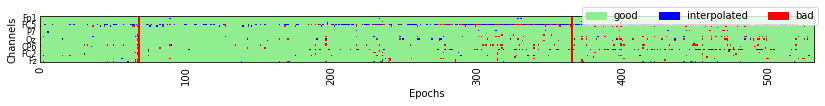

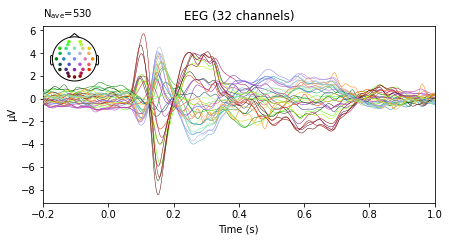

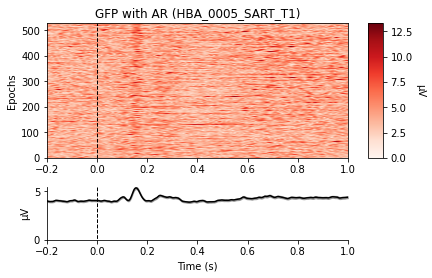

Number of events,530
Events,GO trial: 474NO-GO trial: 56
Time range,-0.200 – 1.000 sec
Baseline,off


In [26]:
# Loop through all the subjects' directories (EEG files directories)
for i in range(len(file_dirs)):
        print('\n{} ({} / {})'.format(subject_names[i], i+1, len(file_dirs)))
        # Read in the raw EEG data
        try:
                raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                        stim_channel=stimulus_channel).drop_channels(['Erg1'])
        except:
                raw = mne.io.read_raw_bdf(file_dirs[i], infer_types=True, eog=eog_channels,
                                        stim_channel=stimulus_channel)

        # Set the right montage (Biosemi32) and set reference as average across all channels
        raw = raw.set_montage(mne.channels.make_standard_montage('biosemi32')).load_data()\
                 .set_eeg_reference(ref_channels='average', verbose=False)
    
        # Filter the signal with bandpass filter and remove EOG artefacts with SSP
        filt = prep.filter_raw_data(raw,filter_design, line_remove=None, eog_channels=eog_channels,
                                    plot_filt=False, savefig=False, verbose=False)
        
        # Find events from the filtered EEG data and name them
        events = mne.find_events(filt, stim_channel=stimulus_channel, consecutive=False, output='onset')
        
        # Create an array of successful GO (followed with button press) and NO-GO trials (no button press)
        success_go_nogo_events = []
        for m in range(len(events)):
                if events[m][2] == event_dict['GO trial'] and events[m+1][2] == button_id:
                        success_go_nogo_events.append(events[m])
                if events[m][2] == event_dict['NO-GO trial'] and events[m+1][2] != button_id:
                        success_go_nogo_events.append(events[m])
        success_go_nogo_events = np.asarray(success_go_nogo_events)
        
        # Plot all the events
        %matplotlib inline
        fig, axs = plt.subplots(1, 1, figsize=(10, 5))
        fig = mne.viz.plot_events(success_go_nogo_events, sfreq=filt.info['sfreq'],
                                  first_samp=filt.first_samp, event_id=event_dict,
                                  axes=axs, show=False)
        fig.subplots_adjust(right=0.7)
        axs.set_title('Successful events ({})'.format(subject_names[i]))
        plt.show()

        # Create epochs time-locked to successful GO and NO-GO events
        picks = mne.pick_types(filt.info, eeg=True, stim=False)
        epochs = mne.Epochs(filt, success_go_nogo_events, event_id=event_dict,
                            tmin=tminmax[0], tmax=tminmax[1], baseline=baseline_correction,
                            picks=picks, preload=True)
        
        # Plot the epochs' GFP plot before artefact rejection
        epochs.plot_image(title="GFP without AR ({})".format(subject_names[i]))

        # Use AutoReject to repair and remove epochs which are artefactual
        reject_criteria = get_rejection_threshold(epochs)
        print('Dropping epochs with rejection threshold:',reject_criteria)
        epochs.drop_bad(reject=reject_criteria)

        ar = AutoReject(thresh_method='random_search', random_state=1)
        ar.fit(epochs)
        epochs_ar, reject_log = ar.transform(epochs, return_log=True)
        reject_log.plot('horizontal')

        # Plot the epochs' GFP after artefact rejection
        epochs_ar.average().plot()
        epochs_ar.plot_image(title="GFP with AR ({})".format(subject_names[i]))

        # Display the final epochs object meta-data
        display(epochs_ar)

        # Save the cleaned EEG file as .fif file
        try:
                os.makedirs(export_dir)
        except FileExistsError:
                pass
        try:
                mne.Epochs.save(epochs_ar, fname='{}/{}_clean-epo.fif'.format(export_dir,
                                                                              subject_names[i]),
                                                                              overwrite=True)
        except FileExistsError:
                pass

In [27]:
import pandas as pd

df_gotrials = pd.DataFrame(events[events[:,2]==4][:,0]/epochs.info['sfreq'])
df_gotrials['Event'] = 'GO'
df_nogotrials = pd.DataFrame(events[events[:,2]==8][:,0]/epochs.info['sfreq'])
df_nogotrials['Event'] = 'NO-GO'

df_trials = pd.concat([df_gotrials, df_nogotrials]).sort_values(by=0).reset_index(drop=True)
df_trials = df_trials.rename(columns={0: 'Timepoint'})

df_trials['Difference'] = df_trials['Timepoint'].diff()

In [28]:
df_trials

,Timepoint,Event,Difference
0,75.270508,GO,NaN
1,76.970703,GO,1.700195
2,79.287109,NO-GO,2.316406
3,81.419922,GO,2.132812
4,83.070312,GO,1.650391
...,...,...,...
535,1071.172852,NO-GO,1.983398
536,1073.206055,GO,2.033203
537,1075.489258,GO,2.283203
538,1077.505859,GO,2.016602


In [29]:
df_trials.describe()

,Timepoint,Difference
count,540.000000,539.000000
mean,579.577698,1.862064
std,290.615291,0.289039
min,75.270508,1.333008
25%,328.733398,1.616211
50%,582.521484,1.882812
75%,831.163818,2.116211
max,1078.922852,2.483398
